In [2]:
import ROOT as rt
import uproot
#from root_pandas import read_root
import h5py 

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Welcome to JupyROOT 6.22/02


In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

import json
from prettytable import PrettyTable 

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'

gpu-ibanks-2.hep.caltech.edu  Tue Aug 17 14:44:24 2021  470.57.02
[0] NVIDIA TITAN Xp  | 28'C,   0 % |     1 / 12196 MB |
[1] NVIDIA TITAN Xp  | 28'C,   0 % |     1 / 12196 MB |
[2] NVIDIA TITAN Xp  | 30'C,   0 % |     1 / 12196 MB |
[3] NVIDIA TITAN Xp  | 25'C,   0 % |     1 / 12196 MB |
[4] NVIDIA TITAN Xp  | 26'C,   0 % |     1 / 12196 MB |
[5] NVIDIA TITAN Xp  | 24'C,   0 % |     1 / 12196 MB |


In [4]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [5]:
# Set up dataframes - 2018 (recon == 1)

# Signals
GluGluToHH_df_2018 = samp_to_df('job_5_ntuple20180805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHH_df_2018 = samp_to_df('job_1_ntuple20180809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job1ifile', 2)

# Backgrounds
TTGJets_df_2018 = samp_to_df('job_2_ntuple20180805v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job2ifile', 19)
TTGG_0Jets_df_2018 = samp_to_df('job_3_ntuple20180805v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job3ifile', 28)
TTJets_df_2018 = samp_to_df('job_4_ntuple20180805v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job4ifile', 304)
VHToGG_df_2018 = samp_to_df('job_6_ntuple20180805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job6ifile', 1)
ttHToGG_df_2018 = samp_to_df('job_7_ntuple20180805v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job7ifile', 2)
VBFHToGG_df_2018 = samp_to_df('job_8_ntuple20180805v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job8ifile', 4)
GluGluHToGG_df_2018 = samp_to_df('job_9_ntuple20180805v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job9ifile', 3)
GJet_SmallPt_df_2018 = samp_to_df('job_10_ntuple20180805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job10ifile', 15)
GJet_BigPt_df_2018 = samp_to_df('job_11_ntuple20180805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 10)
DiPhotonJetsBox2B_df_2018 = samp_to_df('job_12_ntuple20180805v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob12ifile', 2)
DiPhotonJetsBox1B_df_2018 = samp_to_df('job_13_ntuple20180805v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob13ifile', 3)
DiPhotonJetsBox_df_2018 = samp_to_df('job_14_ntuple20180805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob14ifile', 23)
QCD_Jets_df_2018 = samp_to_df('job_2_ntuple20180809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job2ifile', 78)


# Set up dataframes - 2017 (recon == 1)

# Signals
GluGluToHH_df_2017 = samp_to_df('job_8_ntuple20170805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job8ifile', 15)
VBFHH_df_2017 = samp_to_df('job_1_ntuple20170809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob1ifile', 6)

# Backgrounds
DiPhotonJetsBox1B_df_2017 = samp_to_df('job_2_ntuple20170805v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob2ifile', 15)
DiPhotonJetsBox2B_df_2017 = samp_to_df('job_3_ntuple20170805v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob3ifile', 25)
DiPhotonJetsBox_df_2017 = samp_to_df('job_4_ntuple20170805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob4ifile', 83)
GJet_SmallPt_df_2017 = samp_to_df('job_5_ntuple20170805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job5ifile', 11)
GJet_BigPt_df_2017 = samp_to_df('job_6_ntuple20170805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job6ifile', 104)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170805v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 1)
TTGG_0Jets_df_2017 = samp_to_df('job_9_ntuple20170805v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job9ifile', 8)
TTGJets_df_2017 = samp_to_df('job_10_ntuple20170805v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job10ifile', 53)
TTJets_df_2017 = samp_to_df('job_11_ntuple20170805v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job11ifile', 194)
VBFHToGG_df_2017 = samp_to_df('job_12_ntuple20170805v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job12ifile', 11)
VHToGG_df_2017 = samp_to_df('job_13_ntuple20170805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job13ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_14_ntuple20170805v1/ttHToGG_M125_13TeV_powheg_pythia8Job14ifile', 3)
QCD_Jets_df_2017 = samp_to_df('job_2_ntuple20180809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job2ifile', 18)


# Set up dataframes - 2016 (recon == 1)

# Signals
GluGluToHH_df_2016 = samp_to_df('job_8_ntuple20160805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job8ifile', 3)
VBFHH_df_2016 = samp_to_df('job_1_ntuple20160809v2/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob1ifile', 0)

# Background
DiPhotonJetsBox1B_df_2016 = samp_to_df('job_2_ntuple20160805v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob2ifile', 17)
DiPhotonJetsBox2B_df_2016 = samp_to_df('job_3_ntuple20160805v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob3ifile', 23)
DiPhotonJetsBox_df_2016 = samp_to_df('job_4_ntuple20160805v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob4ifile', 48)
GJet_SmallPt_df_2016 = samp_to_df('job_5_ntuple20160805v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job5ifile', 13)
GJet_BigPt_df_2016 = samp_to_df('job_6_ntuple20160805v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job6ifile', 64)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160805v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTGG_0Jets_df_2016 = samp_to_df('job_9_ntuple20160805v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job9ifile', 2)
TTGJets_df_2016 = samp_to_df('job_10_ntuple20160805v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job10ifile', 12)
TTJets_df_2016 = samp_to_df('job_11_ntuple20160805v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job11ifile', 43)
VBFHToGG_df_2016 = samp_to_df('job_12_ntuple20160805v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job12ifile', 11)
VHToGG_df_2016 = samp_to_df('job_13_ntuple20160805v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job13ifile', 1)
ttHToGG_df_2016 = samp_to_df('job_14_ntuple20160805v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job14ifile', 0)
QCD_Jets_df_2016 = samp_to_df('job_2_ntuple20160809v2/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job2ifile', 15)


# Combine by sample (recon == 1)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
TTGJets_df = pd.concat([TTGJets_df_2018, TTGJets_df_2017, TTGJets_df_2016], ignore_index=True)
TTGG_0Jets_df = pd.concat([TTGG_0Jets_df_2018, TTGG_0Jets_df_2017, TTGG_0Jets_df_2016], ignore_index=True)
TTJets_df = pd.concat([TTJets_df_2018, TTJets_df_2017, TTJets_df_2016], ignore_index=True)
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)
GJet_SmallPt_df = pd.concat([GJet_SmallPt_df_2018, GJet_SmallPt_df_2017, GJet_SmallPt_df_2016], ignore_index=True)
GJet_BigPt_df = pd.concat([GJet_BigPt_df_2018, GJet_BigPt_df_2017, GJet_BigPt_df_2016], ignore_index=True)
DiPhotonJetsBox2B_df = pd.concat([DiPhotonJetsBox2B_df_2018, DiPhotonJetsBox2B_df_2017, DiPhotonJetsBox2B_df_2016], ignore_index=True)
DiPhotonJetsBox1B_df = pd.concat([DiPhotonJetsBox1B_df_2018, DiPhotonJetsBox1B_df_2017, DiPhotonJetsBox1B_df_2016], ignore_index=True)
DiPhotonJetsBox_df = pd.concat([DiPhotonJetsBox_df_2018, DiPhotonJetsBox_df_2017, DiPhotonJetsBox_df_2016], ignore_index=True)
QCD_Jets_df = pd.concat([QCD_Jets_df_2018, QCD_Jets_df_2017, QCD_Jets_df_2016], ignore_index=True)

In [6]:
class AMSGrad(optim.Optimizer):
    """Implements AMSGrad algorithm.
    It has been proposed in `On the Convergence of Adam and Beyond (https://openreview.net/forum?id=ryQu7f-RZ)`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AMSGrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AMSGrad, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', True)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

### Preprocessing

In [15]:
training_vars = [b'leading_photon_pt', b'leading_photon_eta', b'leading_photon_phi', 
                 b'subleading_photon_pt', b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

BKD_dfs = [TTGJets_df, TTGG_0Jets_df, TTJets_df, VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df,
            GJet_SmallPt_df, GJet_BigPt_df, DiPhotonJetsBox2B_df, DiPhotonJetsBox1B_df, DiPhotonJetsBox_df, QCD_Jets_df]

names = ['TTG Jets', 'TTGG_0Jets', 'TTJets', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox', 'QCD_Jets']

i = 1 # select sample

sig_frame_all = GluGluToHH_df
bkg_frame_all = BKD_dfs[i]

sig_frame = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars]

sig_aux_frame = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][aug_vars]
bkg_aux_frame = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][aug_vars]

sig_df = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][w_var]
bkg_weight = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][w_var]

# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


### Training

In [28]:
EPOCHS=100
model_file = 'SimpleDNN.torch'
config_file = 'BestConfig.json'
retrain=True

class EventHLF(Dataset):
    def __init__(self, data_x, data_y):
        self.len = data_x.shape[0]
        self.data_x = torch.from_numpy(data_x).float()
        self.data_y = torch.from_numpy(data_y).long()
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data_x[idx], self.data_y[idx])


class SimpleDNN(nn.Module):
    def __init__(self, num_hiddens=2, initial_node=500, dropout=0.5):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(18, initial_node)
        self.dropout = dropout
        self.hiddens = nn.ModuleList()
        nodes = [initial_node]
        for i in range(num_hiddens):
            nodes.append(int(nodes[i]/2))
            self.hiddens.append(nn.Linear(nodes[i],nodes[i+1]))
        self.out = nn.Linear(nodes[-1],2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for i in range(len(self.hiddens)):
            x = F.relu(self.hiddens[i](x))
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

class EarlyStopping():
    """
    Early Stopping to terminate training early under certain conditions
    """

    def __init__(self, 
                 monitor='val_loss',
                 min_delta=0,
                 patience=10):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.stopped_epoch = 0
        self.stop_training= False
        #print("This is my patience {}".format(patience))
    
    def on_train_begin(self):
        self.wait = 0
        self.best_loss = 1e15
    
    def on_epoch_end(self, epoch, current_loss):
        if current_loss is None:
            pass
        else:
            if (current_loss - self.best_loss) < -self.min_delta:
                self.best_loss = current_loss
                self.wait = 1
            else:
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch + 1
                    self.stop_training = True
                self.wait += 1
            return  self.stop_training
        
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print('\nTerminated training for early stopping at epoch %04i' % 
                (self.stopped_epoch))

def train(num_epochs, model, criterion, optimizer,scheduler,volatile=False, data_loader=None):
    best_model = model.state_dict()
    best_acc = 0.0
    train_losses ,val_losses = [],[]
    callback = EarlyStopping(patience=20)
    callback.on_train_begin()
    breakdown = False
    for epoch in range(num_epochs):
        if breakdown:
            print("Early stopped.")
            break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train() # Set model to training mode
                volatile=False
            else:
                model.eval() # Set model to evaluate mode
                volatile=True
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (x_data, y_data) in enumerate(data_loader[phase]):
                x_data = Variable(x_data, volatile).cuda()
                y_data = Variable(y_data, volatile=volatile, requires_grad=False).cuda()
                if phase == 'training':
                    optimizer.zero_grad()
                # forward pass
                outputs = model(x_data)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, y_data)
                
                # backward + optimize only if in training phase
                if phase == 'training':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == y_data.data)
                #print("I finished %d batch" % batch_idx)
            
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = 100. * running_corrects / len(data_loader[phase].dataset)
            if phase == 'training':
                train_losses.append(epoch_loss)
            else:
                scheduler.step(epoch_loss)
                val_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                print('Saving..')
                state = {
                        'net': model, #.module if use_cuda else net,
                        'epoch': epoch,
                        'best_acc':epoch_acc,
                        'train_loss':train_losses,
                        'val_loss':val_losses,
                        }
                torch.save(state, model_file)
                best_acc = epoch_acc
                best_model = model.state_dict()
            if phase == 'validation':
                breakdown = callback.on_epoch_end(epoch, -epoch_acc)
                
         
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model)
    print('-' * 10)
    return best_acc





In [22]:
space  = [Integer(1, 5, name='max_depth'),
          Integer(200, 1000, name='initial_nodes'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Real(0.01,0.9,name='dropout'),
          Integer(32,512,name='batch_size')
          ]

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    fom = []
    for train_index, test_index in skf.split(data, label):
        train_loader = DataLoader(EventHLF(data[train_index], label[train_index]), batch_size = X['batch_size'], shuffle=True)
        val_loader = DataLoader(EventHLF(data[test_index], label[test_index]), batch_size = X['batch_size'], shuffle=True)
        data_loader = {"training": train_loader, "validation": val_loader} 

        model = SimpleDNN(X['max_depth'], X['initial_nodes'], X['dropout']).cuda()
        optimizer = AMSGrad(model.parameters(), lr=X['learning_rate'])
        criterion= nn.NLLLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=5)
        best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
        fom.append(best_acc)
    Y = np.mean(np.asarray(fom))
    print("Average best_acc across k-fold: {}".format(Y))
    return -Y

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best parameters: {}".format(res_gp.x))
best_max_depth = res_gp.x[0]
best_initial_nodes = res_gp.x[1]
best_learning_rate = res_gp.x[2]
best_dropout = res_gp.x[3]
best_batch_size = res_gp.x[4]

bestconf = {"max_depth": best_max_depth,
          "initial_nodes": best_initial_nodes,
          "learning_rate": best_learning_rate,
          "dropout": best_dropout,
          "batch_size": best_batch_size}
with open(config_file, 'w') as config:
    json.dump(bestconf, config)
    print("Save best configuration to {}".format(config_file))

train_index, test_index = skf.split(data, label).next()
model = SimpleDNN(best_max_depth, best_initial_nodes, best_dropout).cuda()
train_loader = DataLoader(EventHLF(data[train_index], label[train_index]), batch_size = best_batch_size, shuffle=True)
val_loader = DataLoader(EventHLF(data[test_index], label[test_index]), batch_size = best_batch_size, shuffle=True)
data_loader = {"training": train_loader, "validation": val_loader}
optimizer = AMSGrad(model.parameters(), lr=best_learning_rate)
criterion= nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=5)
best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)

torch.save(model.state_dict(), model_file)

New configuration: {'learning_rate': 0.19486241836466403, 'initial_nodes': 875, 'dropout': 0.7640540475178719, 'batch_size': 331, 'max_depth': 3}
Epoch 0/99
training Loss: 0.5080 Acc: 49.8333
validation Loss: 0.0022 Acc: 50.0000
Saving..
Epoch 1/99
training Loss: 0.0022 Acc: 49.6429
validation Loss: 0.0022 Acc: 50.0000
Epoch 2/99
training Loss: 0.0021 Acc: 50.0923
validation Loss: 0.0022 Acc: 50.0000
Epoch 3/99
training Loss: 0.0021 Acc: 49.9821
validation Loss: 0.0022 Acc: 49.9762
Epoch 4/99
training Loss: 0.0028 Acc: 49.7708
validation Loss: 0.0021 Acc: 50.0000
Epoch 5/99
training Loss: 0.0116 Acc: 49.8065
validation Loss: 0.0021 Acc: 50.0000
Epoch 6/99
training Loss: 0.0021 Acc: 50.1786
validation Loss: 0.0021 Acc: 50.0000
Epoch 7/99
training Loss: 0.0021 Acc: 50.2827
validation Loss: 0.0021 Acc: 50.0000
Epoch 8/99
training Loss: 0.0021 Acc: 49.5506
validation Loss: 0.0022 Acc: 50.0000
Epoch 9/99
training Loss: 0.0021 Acc: 50.4345
validation Loss: 0.0021 Acc: 50.0000
Epoch 10/99
tra

In [6]:
with open(config_file) as f:
    best_conf = json.load(f)
print("Loaded best configuration from {}".format(config_file))
model = SimpleDNN(best_conf["max_depth"], best_conf["initial_nodes"], best_conf["dropout"]).cuda()
model.load_state_dict(torch.load(model_file))
print("Loaded best model parameter from {}".format(model_file))


Loaded best configuration from BestConfig.json
Loaded best model parameter from SimpleDNN.torch


In [29]:
best_max_depth = 2
best_initial_nodes = 128
best_learning_rate = 0.0036864344871878527
best_dropout = 0.6935861755978148
best_batch_size = 40

bestconf = {"max_depth": best_max_depth,
          "initial_nodes": best_initial_nodes,
          "learning_rate": best_learning_rate,
          "dropout": best_dropout,
          "batch_size": best_batch_size}
#with open(config_file, 'w') as config:
   # json.dump(bestconf, config)
    #print("Save best configuration to {}".format(config_file))

train_index, test_index = next(skf.split(data, label))
model = SimpleDNN(best_max_depth, best_initial_nodes, best_dropout).cuda()
train_loader = DataLoader(EventHLF(data[train_index], label[train_index]), batch_size = best_batch_size, shuffle=True)
val_loader = DataLoader(EventHLF(data[test_index], label[test_index]), batch_size = best_batch_size, shuffle=True)
data_loader = {"training": train_loader, "validation": val_loader}
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
criterion= nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=5)
best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
torch.save(model.state_dict(), model_file)

Epoch 0/99
training Loss: 0.0099 Acc: 83.7444


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


validation Loss: 0.0070 Acc: 88.6144
Saving..
Epoch 1/99


/usr/local/lib64/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SimpleDNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


training Loss: 0.0077 Acc: 88.8628
validation Loss: 0.0061 Acc: 90.4371
Saving..
Epoch 2/99
training Loss: 0.0074 Acc: 89.4164
validation Loss: 0.0060 Acc: 90.5834
Saving..
Epoch 3/99
training Loss: 0.0073 Acc: 89.5900
validation Loss: 0.0059 Acc: 90.5747
Epoch 4/99
training Loss: 0.0072 Acc: 89.7367
validation Loss: 0.0058 Acc: 90.6112
Saving..
Epoch 5/99
training Loss: 0.0071 Acc: 89.8451
validation Loss: 0.0060 Acc: 90.7697
Saving..
Epoch 6/99
training Loss: 0.0070 Acc: 89.9182
validation Loss: 0.0060 Acc: 90.3780
Epoch 7/99
training Loss: 0.0070 Acc: 90.0562
validation Loss: 0.0058 Acc: 90.8863
Saving..
Epoch 8/99
training Loss: 0.0069 Acc: 90.1485
validation Loss: 0.0059 Acc: 90.4284
Epoch 9/99
training Loss: 0.0069 Acc: 90.2002
validation Loss: 0.0059 Acc: 90.9472
Saving..
Epoch 10/99
training Loss: 0.0068 Acc: 90.2586
validation Loss: 0.0057 Acc: 90.8550
Epoch 11/99
training Loss: 0.0068 Acc: 90.2533
validation Loss: 0.0059 Acc: 91.0186
Saving..
Epoch 12/99
training Loss: 0.0068

### Performance

Saved ROC.
Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.2985  |       0.9602      |    0.1157 +/- 0.0017     |
|   0.4618  |       0.9352      |    0.0776 +/- 0.0005     |
|   0.6523  |       0.9002      |    0.0516 +/- 0.0015     |
|   0.9287  |       0.7001      |    0.0124 +/- 0.0007     |
|   0.9851  |       0.5001      |    0.0038 +/- 0.0003     |
+-----------+-------------------+--------------------------+


ValueError: Length of passed values is 57440, index implies 143601.

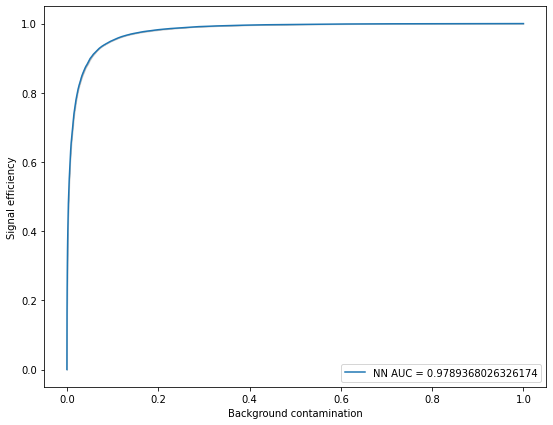

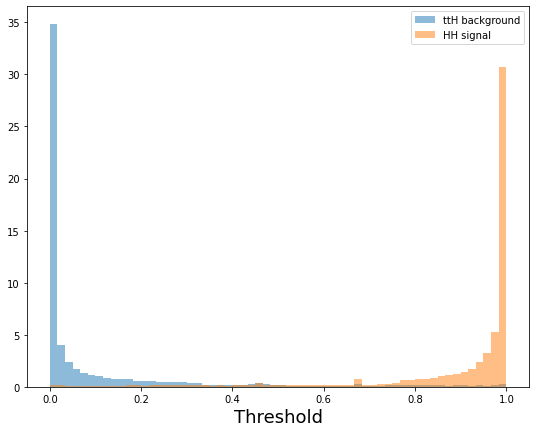

In [51]:
fprs = []
base_tpr = np.linspace(0, 1, 5000)
thresholds = []

for train_index, test_index in skf.split(data, label):
    x_val = data[test_index]
    y_val = label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    model.eval()
    pred = model(Variable(torch.from_numpy(x_val).float().cuda(), True)).cpu().data.numpy()

    fpr, tpr, threshold = roc_curve(y_val, np.exp(pred)[:,1])
    
    fpr = np.interp(base_tpr, tpr, fpr)
    threshold = np.interp(base_tpr, tpr, threshold)
    fpr[0] = 0.0
    fprs.append(fpr)
    thresholds.append(threshold)
    

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs + std_fprs, 1)
fprs_left = np.maximum(mean_fprs - std_fprs,0)

mean_area = auc(mean_fprs, base_tpr)


with h5py.File("DNN_ROC.h5","w") as out:
    out['FPR'] = mean_fprs
    out['dFPR'] = std_fprs
    out['TPR'] = base_tpr
    out['Thresholds'] = mean_thresholds
    print("Saved ROC.")

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5]
print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
print(NNtable)

plt.figure(figsize=(9,7))
plt.plot(mean_fprs, base_tpr,label="NN AUC = {}".format(mean_area))
plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')

plt.figure(figsize=(9,7))
plt.hist(np.exp(pred)[y_val==0,1], bins=60, label='ttH background',alpha=0.5, density =True)
plt.hist(np.exp(pred)[y_val==1,1], bins=60, label='HH signal', alpha=0.5, density =True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)
# sig_frame = pd.DataFrame.from_records(signp)
# bkg_frame = pd.DataFrame.from_records(bkgnp)

#sig_frame['NN_score'] = pd.Series(np.exp(pred[:len(signal),1]), index=sig_frame.index)
#bkg_frame['NN_score'] = pd.Series(np.exp(pred[len(signal):,1]), index=bkg_frame.index)

In [40]:
# scale weights to match original
sig_total_weight = np.sum(sig_frame_all.loc[:, b'genweight'].values)
bgd_total_weight = np.sum(bkg_frame_all.loc[:, b'genweight'].values)

sig_test_weights = test_weight[y_val == 1]
bgd_test_weights = test_weight[y_val == 0]
sig_test_total_weight = np.sum(sig_test_weights)
bgd_test_total_weight = np.sum(bgd_test_weights)

scale_sig = sig_total_weight / sig_test_total_weight
scale_bgd = bgd_total_weight / bgd_test_total_weight

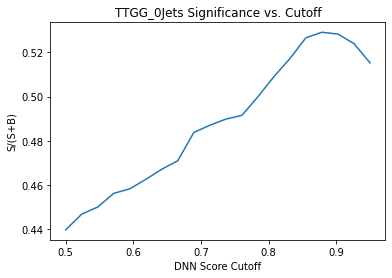

In [41]:
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = np.exp(pred)[y_val == 0,1]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = np.exp(pred)[y_val == 1, 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_val == 1].flatten()
    bgd_weight = test_weight[y_val == 0].flatten()
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)


test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/ttH_score/' + names[i]+'_ttHscore_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = names[i])
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.title(names[i] + ' Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/ttH_score/{names[i]}_ttHscore_significance', format='png')
plt.show()

## Root tree

In [44]:
bgd_x_all = x_all_test[y_val == 0]
bgd_y = np.exp(pred)[y_val == 0, 1]

sig_x_all = x_all_test[y_val == 1]
sig_y = np.exp(pred)[y_val == 1, 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'genweight_scale'] = result_sig_df.loc[:, b'genweight'].values * scale_sig
result_sig_df[b'DNN score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'genweight_scale'] = result_bgd_df.loc[:, b'genweight'].values * scale_bgd
result_bgd_df[b'DNN score'] = bgd_y

result_sig_df_alt = pd.DataFrame()
result_bgd_df_alt = pd.DataFrame()
for column in list(result_sig_df.columns):
    result_sig_df_alt[column] = result_sig_df.loc[:, column].values
    result_bgd_df_alt[column] = result_bgd_df.loc[:, column].values
    
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df_alt[key].values for key in list(result_sig_df_alt.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df_alt[key].values for key in list(result_bgd_df_alt.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)
sig_rdf.Snapshot('tree', f'DNN_Trees/ttH_score/{names[i]}_ttHscore_sig_DNN_file.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/ttH_score/{names[i]}_ttHscore_bgd_DNN_file.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x955eb570>

## Check mass sculpting

(28720,)
(28720,)
(5, 5000)
5


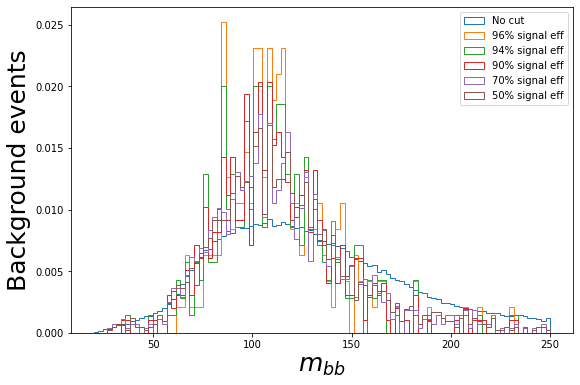

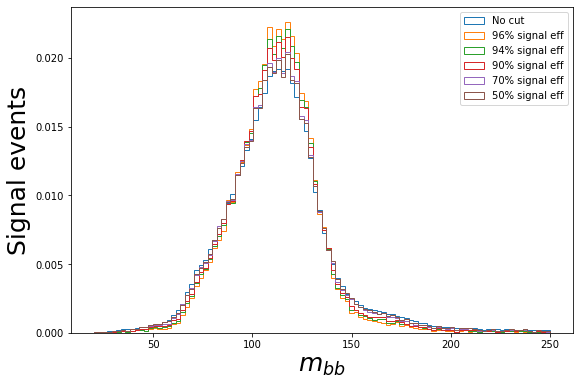

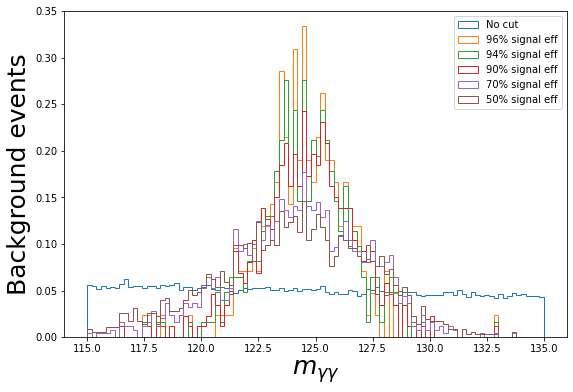

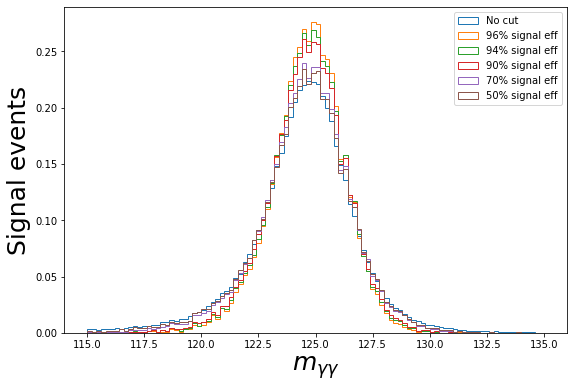

In [71]:
bkg_test_mjj = bgd_x_all[:, 19]
bkg_test_mgg = bgd_x_all[:, 20]
sig_test_mjj = sig_x_all[:, 19]
sig_test_mgg = sig_x_all[:, 20]
print(bkg_test_mjj.shape)
print(bgd_y.shape)
print(thresholds.shape)
print(len(TPR_thresholds))

fontsize=25

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame[b'dibjet_mass'], bins=100, histtype='step', label='No cut', density=True, range=(20, 250))
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print(TPR_threshold)
    #print(thres_idx)
    #thres = thresholds[thres_idx]
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_test_mjj[bgd_y > TPR_threshold], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True, range=(20, 250))
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)
plt.savefig(fname = f'Mass_Sculpt_Plts/ttH_score/{names[i]}_bgd_mjj_mass_sculpt')

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame[b'dibjet_mass'], bins=100, histtype='step', label='No cut', density=True, range=(20, 250))
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_test_mjj[sig_y > TPR_threshold], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True, range = (20, 250))
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)
plt.savefig(fname = f'Mass_Sculpt_Plts/ttH_score/{names[i]}_sig_mjj_mass_sculpt')

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame[b'diphoton_mass'], bins=100, range=(115,135), histtype='step', label='No cut', density=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_test_mgg[bgd_y > TPR_threshold], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True, range = (115, 135))
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)
plt.savefig(fname = f'Mass_Sculpt_Plts/ttH_score/{names[i]}_bgd_mgg_mass_sculpt')

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame[b'diphoton_mass'], bins=100, range=(115,135), histtype='step', label='No cut', density=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_test_mgg[sig_y > TPR_threshold], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True, range=(115, 135))
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)
plt.savefig(fname = f'Mass_Sculpt_Plts/ttH_score/{names[i]}_sig_mgg_mass_sculpt')

### BDT benchmark

In [72]:
bdtfile = rt.TFile.Open("TMVA.root")
bdttree = bdtfile.Get("TestTree")
bdtscore = tree2array(bdttree,
                        branches = ['classID','BDT'])
bdtframe = pd.DataFrame.from_records(bdtscore)
bdtarray = bdtframe.values

bdt_pred = bdtarray[:,1]
bdt_target = np.zeros(shape=len(bdt_pred))
bdt_target[bdtarray[:,0]==0] = 1 # Signal
bdt_target[bdtarray[:,0]==1] = -1 # Background

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(bdt_target, bdt_pred)
area_bdt = auc(fpr_bdt, tpr_bdt)

with h5py.File("BDT_ROC.h5","w") as out:
    out['FPR'] = fpr_bdt
    out['TPR'] = tpr_bdt
    out['Thresholds'] = thresholds_bdt
    print("Saved ROC.")

TPR_thresholds = [0.96, 0.94, 0.935, 0.9, 0.7, 0.5, 0.3]
print("BDT performance")
print("Threshold \tSignal Efficiency \tBackground contamination")
for TPR_threshold in TPR_thresholds:
    thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
    print("{0:.4}  \t   {1:.4}   \t\t  {2:.4}".format(thresholds_bdt[thres_bdt_idx], tpr_bdt[thres_bdt_idx],  fpr_bdt[thres_bdt_idx]))


# TPR_threshold = 0.96
# thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
# print("Signal efficiency = {} @ {} ttH background contamination".format(tpr_bdt[thres_bdt_idx], fpr_bdt[thres_bdt_idx]))
# print("NN score threshold = {}".format(thresholds_bdt[thres_bdt_idx]))

plt.figure(figsize=(9,7))
plt.plot(fpr_bdt,tpr_bdt,label="AUC = {}".format(area_bdt))
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
plt.axhline(tpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')
plt.axvline(fpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')
plt.show()

plt.figure(figsize=(9,7))
plt.hist(bdt_pred[bdt_target==-1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(bdt_pred[bdt_target==1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds_bdt[thres_bdt_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.show()

ReferenceError: attempt to access a null-pointer

Error in <TFile::TFile>: file TMVA.root does not exist


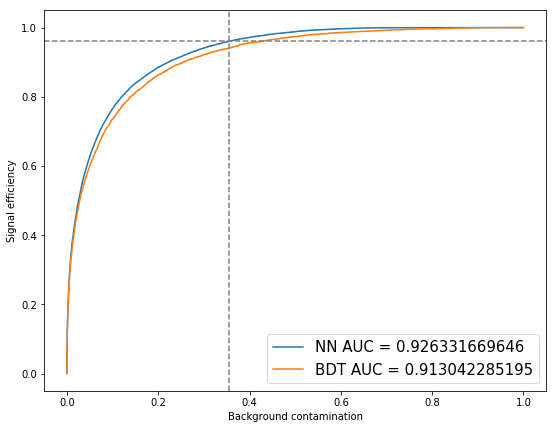

In [29]:
### Compare
plt.figure(figsize=(9,7))
plt.plot(fpr,tpr,label="NN AUC = {}".format(area))
plt.plot(fpr_bdt,tpr_bdt,label="BDT AUC = {}".format(area_bdt))
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
thres_idx = np.argmax(tpr>0.96)
# plt.xlim(0.01,0.6)
# plt.ylim(0.2,1)
plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='best',fontsize=15)

## Show variables used

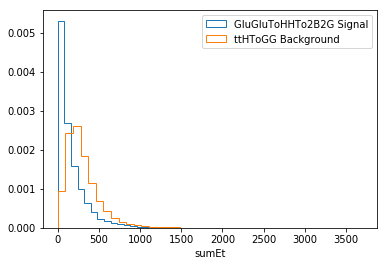

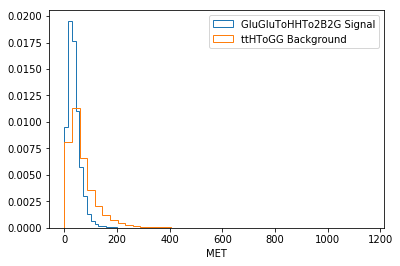

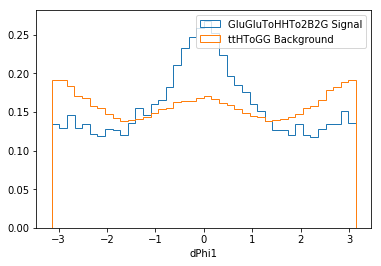

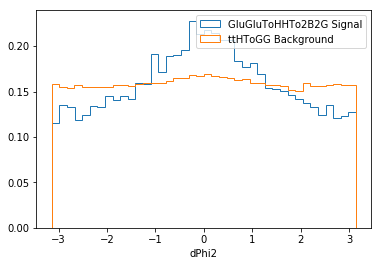

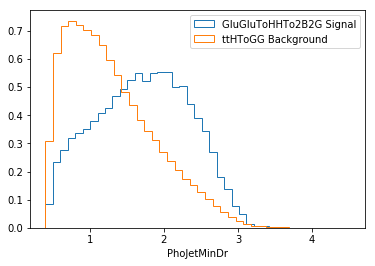

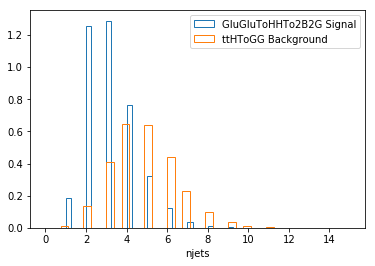

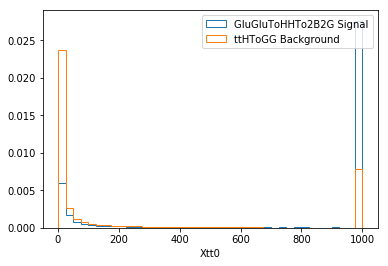

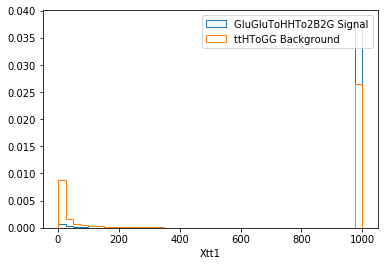

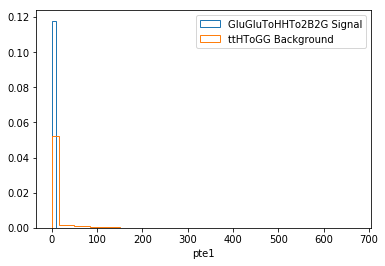

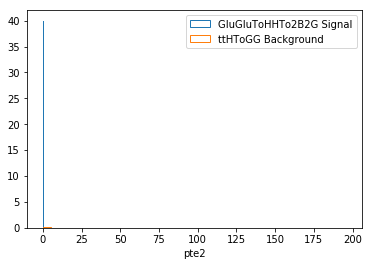

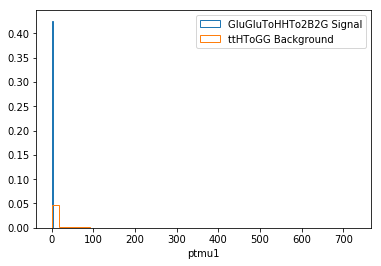

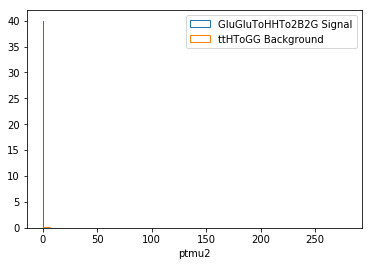

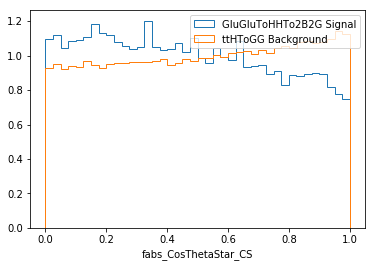

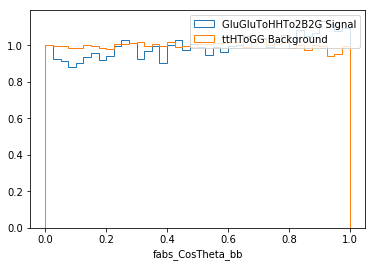

In [33]:
HLFs = ['sumEt','MET','dPhi1','dPhi2','PhoJetMinDr','njets','Xtt0',
        'Xtt1','pte1','pte2','ptmu1','ptmu2','fabs_CosThetaStar_CS','fabs_CosTheta_bb']

for hlf in training_vars:
    plt.figure()
    plt.hist(sig_frame[hlf], bins=40, normed=True, histtype='step', label='GluGluToHHTo2B2G Signal')
    plt.hist(bkg_frame[hlf], bins=40, normed=True, histtype='step', label='ttHToGG Background')
    plt.xlabel(hlf)
    plt.legend(loc='best')
    

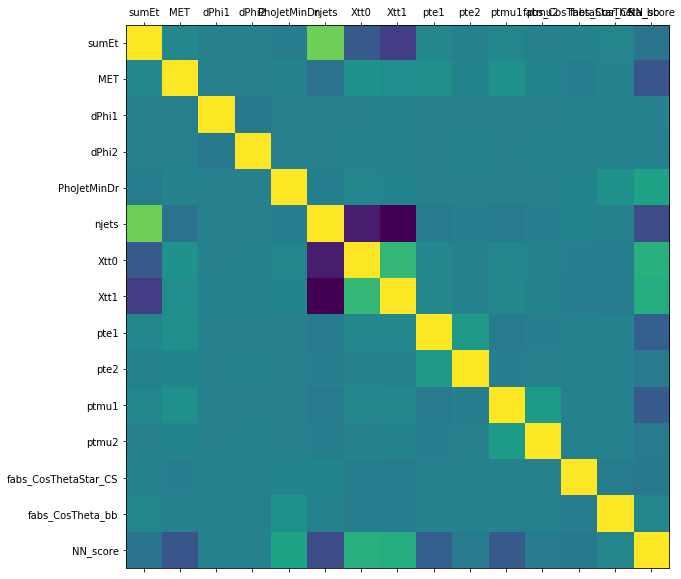

In [35]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

plot_corr(bkg_frame)